# Political tweets - simple classifier

This project performs simple text classification to predict the political leaning of tweets based on their content. Our ambition is to create a model that can accurately classify tweets as either Republican or Democratic with the help of a Logistic Regression pipeline trained on preprocessed data.

We begin by installing necessary libraries such as `tweet-preprocessor`, `imbalanced-learn`, and `gradio`. Then, we import required Python modules like `pandas`, `numpy`, `spacy`, `scikit-learn`, and `eli5` for data manipulation, text preprocessing, machine learning, and model explanation.

The dataset consists of two parts: `data_pol` from the PolitiFact Twitter dataset and `data_tw` from a presidential debate tweet dataset. We clean and preprocess the textual data using both custom functions and spaCy's NLP capabilities to remove special characters, lowercase, lemmatize tokens, and filter out non-alphabetical characters.

To handle imbalanced datasets, we use `RandomUnderSampler` from `imbalanced-learn` to balance the number of Republican and Democratic tweets in our training set. We then split the data into a training set and test set using `train_test_split`.

Next, we create a pipeline with `TfidfVectorizer` for text representation and `LogisticRegression` as the classifier. The model is trained on the preprocessed training set and evaluated on both the training and test sets using classification reports to assess its performance. We also use `eli5` to visualize top features and explain a single prediction.

Finally, we create a Gradio interface that allows users to input text and receive predictions about its political leaning along with probability scores for each class. This user-friendly interface makes it easy to test the model's accuracy on new data.

Overall, this project demonstrates how to build a machine learning pipeline for text classification using Python libraries and Gradio to create an interactive web application.


In [ ]:
# Install the tweet-preprocessor library (used for cleaning and preprocessing tweets)
!pip install tweet-preprocessor -q
# Install or update the imbalanced-learn library, useful for dealing with imbalanced datasets
!pip install -U imbalanced-learn -q
!pip install gradio -U -q

In [ ]:
!pip install mapply

In [ ]:
import pandas as pd
import mapply
import numpy as np
import preprocessor as prepro # twitter prepro
from tqdm.notebook import tqdm #progress bar # since or things are now gonna take longer, or if we're stuck in somethign or if it's still working

import spacy #spacy for quick language prepro # Very good if you need to use language processing fast, not so much for neutral networks, hence dying a bit also probably.
nlp = spacy.load('en_core_web_sm') #instantiating English module

# sampling, splitting
from imblearn.under_sampling import RandomUnderSampler # need to bring it to the same distribution
from sklearn.model_selection import train_test_split


# loading ML libraries
from sklearn.pipeline import make_pipeline #pipeline creation
from sklearn.feature_extraction.text import TfidfVectorizer #transforms text to sparse matrix
from sklearn.linear_model import LogisticRegression #Logit model
from sklearn.metrics import classification_report #that's self explanatory

import gradio as gr

In [ ]:
import matplotlib.pyplot as plt

import eli5


In [ ]:
mapply.init(
    n_workers=-1,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=True,
)

In [ ]:
# prepro settings
prepro.set_options(prepro.OPT.URL, prepro.OPT.NUMBER, prepro.OPT.RESERVED, prepro.OPT.MENTION) # twitter preprocessor and remove all these.
# Could argue if you're losing information, but whatever

In [ ]:
# open file
data_pol = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pol_tweets.gz')
data_tw = pd.read_json('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/pres_debate_2020.gz')
# just care about the performance evaluation, we don't care about the causality of what is happening. Which you would care a lot about in statistics and colinearity and so on

In [ ]:
data_pol.head(2)

,text,labels
340675,RT @GreenBeretFound Today we remember Sgt. 1st...,0
289492,"Yes, yes, yes, yes and yes. 😷 #JerseyStrong 💪🏾...",1


In [ ]:
data_tw.head(2)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,nretweets,quote_url,search,near,geo,source,reply_to,translate,trans_src,trans_dest
0,1318944772183281664,1318944772183281664,2020-10-21 15:58:33,2020-10-21 15:58:33,0,,Still time to register: Students can join the ...,en,[presidentialdebate2020],[],...,2,,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,
1,1318938583122743296,1318938583122743296,2020-10-21 15:33:57,2020-10-21 15:33:57,0,,Be prepared for Trump to railroad Thursday’s d...,en,[presidentialdebate2020],[],...,0,https://twitter.com/donaldjtrumpjr/status/1318...,PresidentialDebate2020,,,,"{'user_id': None, 'username': None}",,,


In [ ]:
data_pol['text'] = data_pol.text.str.lower()

In [ ]:
#basic cleanup only for tweets
data_pol['text_clean'] = data_pol['text'].mapply(lambda t: prepro.clean(t)) # Anonymus functions, .map (expose them 1 by 1) and call them t lambda(don't have to define), prepro.clean(t)
# can also do it with if and so on, + append but it's easier.
data_pol['text_clean'] = data_pol['text_clean'].str.replace('#','') # str has a lot of features. String manipulations in panadas.
data_pol['text_clean'] = data_pol['text_clean'].str.replace('rt','') # prepro.clean might've made it all same size, but otherwise do one for upper or lower caes

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.


  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
data_pol.head(3)

,text,labels,text_clean
340675,rt @greenberetfound today we remember sgt. 1st...,0,today we remember sgt. st class ryan j. savar...
289492,"yes, yes, yes, yes and yes. 😷 #jerseystrong 💪🏾...",1,"yes, yes, yes, yes and yes. 😷 jerseystrong 💪🏾 ..."
371088,made new friends this afternoon delivering mas...,1,made new friends this afternoon delivering mas...


In [ ]:
# run progress bar and clean up using spacy but without some heavy parts of the pipeline

clean_text = []

pbar = tqdm(total=len(data_pol['text_clean'][:100]),position=0, leave=True) # make a progessbar

for text in nlp.pipe(data_pol['text_clean'][:100], disable=["tagger", "parser", "ner"]): # putting all our text into the loop, and skip tagger parser and ner since they're computationally intense

  txt = [token.lemma_.lower() for token in text # lowercase lematized tokens
         if token # if it's characters (and ont the ones below)
         and not token.is_stop # don't want it to be stop words
         and not token.is_punct] # and don't want it to be dots

  clean_text.append(" ".join(txt))

  pbar.update(1)

  0%|          | 0/100 [00:00<?, ?it/s]

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


In [ ]:
clean_text[:10]

['  today remember sgt st class ryan j. savard killed action day years ago sfc savard assigned u.s army special operations command de oppresso liber',
 'yes yes yes yes yes 😷 jerseystrong 💪 🏾 qt prioritize science politics prioritize data politics prioritize public health politics prioritize facts politics prioritize defeating covid19 politics',
 'new friends afternoon delivering masks veterans st pete beach thanks mayor johnson commissioner graus propey owner tom de yampe making homes available served nation',
 '  happening today pilots texas air guard conducting f-16 flyover honor texans frontlines covid19 pandemic flyover reach lubbock 40 laredo 10 pm corpus christi 40 pm covid19nationalguard',
 '  president trump legal team completely destroyed days adam schiff false allegations hours today devastating democrats case vindicated democrats tore country apa years shameful',
 'decades home supreme cou right decision line health care workers like daca recipients home thank sharing story

In [ ]:
def text_prepro(texts: pd.Series) -> list: # called typing, and then if something breaks, and this ensures that we need a certain type of data coming in and out
    """
    Preprocess a series of texts.

    Parameters:
    - texts: A pandas Series containing the text to be preprocessed.
    - nlp: A spaCy NLP model.

    Returns:
    - A list of preprocessed texts.

    Steps:
    - Clean twitter-specific characters using a predefined 'prepro' method.
    - Normalize the text by lowercasing and lemmatizing.
    - Remove punctuations, stopwords, and non-alphabet characters.
    """
# nlp can be used for if we have different languages
    # Clean twitter-specific characters and other special characters

    texts_cleaned = texts.str.lower()
    texts_cleaned = texts.mapply(prepro.clean).str.replace('#', '')
    texts_cleaned = texts_cleaned.str.replace('#', '')

    # Initialize container for the cleaned texts
    clean_container = []

    # Use tqdm for a progress bar
    pbar = tqdm(total=len(texts_cleaned), position=0, leave=True)

    # Use spaCy's nlp.pipe for efficient text processing
    for doc in nlp.pipe(texts_cleaned, disable=["tagger", "parser", "ner"]):

        # Extract lemmatized tokens that are not punctuations, stopwords, or non-alphabetic
        tokens = [token.lemma_.lower() for token in doc
                  if token and not token.is_stop and not token.is_punct]

        clean_container.append(" ".join(tokens))

        pbar.update(1)

    return clean_container


In [ ]:
data_pol['text_clean'] = text_prepro(data_pol["text"])

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


In [ ]:
data_df = pd.DataFrame({'label':data_pol['labels'], "text":data_pol["text_clean"]})

In [ ]:
data_df.head(2)

,label,text
340675,0,rt today remember sgt st class ryan j. savard ...
289492,1,yes yes yes yes yes 😷 jerseystrong 💪 🏾 qt prio...


In [ ]:
data_df.label.value_counts().reset_index()

,label,count
0,1,31181
1,0,18819


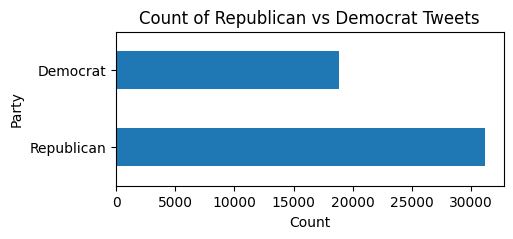

In [ ]:
# Count the occurrences of each label
label_counts = data_df['label'].value_counts()

# Create a horizontal bar plot
plt.figure(figsize=(5, 2))
label_counts.plot(kind='barh')

# Setting the labels and title
plt.xlabel('Count')
plt.ylabel('Party')
plt.yticks(ticks=[0, 1], labels=['Republican', 'Democrat'])
plt.title('Count of Republican vs Democrat Tweets')

plt.show()

In [ ]:
# fixing sample imbalance
rus = RandomUnderSampler(random_state=42)
data_df_res, y_res = rus.fit_resample(data_df, data_df['label']) # for numerical data you can use better models. Making fake data would work better (for the different classes)

In [ ]:
data_df_res['label'].value_counts() # still enough to train a model # losing a bunch of data, but proabably getting better results in the end # 20 and 80% are on the edge, but usually it's fine even if it's 40-60

label
0    18819
1    18819
Name: count, dtype: int64

In [ ]:
# Splitting the dataset into the Training set and Test set (since we have a new output variable) # can also use an eval set around 10% and only in the end we use test set
X_train, X_test, y_train, y_test = train_test_split(data_df_res['text'], y_res, test_size = 0.4, random_state = 42) # best learning material is basically just the documentation (in relation to the imbalanced dataset but also other things we do)


In [ ]:
#instantiate models and "bundle up as pipeline"

tfidf = TfidfVectorizer()
cls_lg = LogisticRegression()

pipe_lg = make_pipeline(tfidf, cls_lg)

In [ ]:
pipe_lg.fit(X_train,y_train) # fit model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [ ]:
# evaluate model performance on training set

y_eval = pipe_lg.predict(X_train)
report = classification_report(y_train, y_eval)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     11292
           1       0.87      0.85      0.86     11290

    accuracy                           0.86     22582
   macro avg       0.86      0.86      0.86     22582
weighted avg       0.86      0.86      0.86     22582



In [ ]:
# evaluate model performance on test set

y_eval = pipe_lg.predict(X_test)
report = classification_report(y_test, y_eval)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.78      0.76      7527
           1       0.77      0.74      0.75      7529

    accuracy                           0.76     15056
   macro avg       0.76      0.76      0.76     15056
weighted avg       0.76      0.76      0.76     15056



In [ ]:
cleaned_twitter_data = data_tw.tweet

In [ ]:
# predict
programmed_tw = text_prepro(cleaned_twitter_data)
new_tw = pipe_lg.predict(programmed_tw) # make with xgb

'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/8811 [00:00<?, ?it/s]

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


In [ ]:
!pip install eli5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107717 sha256=f0a569f18b27dd839ab724140b12cb9ef62a3c682975d6faedcfc1b94dd4618f
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
feature_names = pipe_lg[0].get_feature_names_out()

eli5.show_weights(pipe_lg[1],
                  vec=pipe_lg[0],
                  top=10,
                  feature_names=feature_names) # Show top 10 features

In [63]:
# To explain a single prediction, provide the document and the pipeline
eli5.show_prediction(pipe_lg[1],
                     doc=X_test.iloc[0],
                     vec=pipe_lg[0],
                     target_names=['republican', 'democrat'],
                     feature_names=feature_names) # Adjust target names as needed

In [64]:
def text_prepro2(texts: pd.Series) -> list: # called typing, and then if something breaks, and this ensures that we need a certain type of data coming in and out
    """
    Preprocess a series of texts.

    Parameters:
    - texts: A pandas Series containing the text to be preprocessed.
    - nlp: A spaCy NLP model.

    Returns:
    - A list of preprocessed texts.

    Steps:
    - Clean twitter-specific characters using a predefined 'prepro' method.
    - Normalize the text by lowercasing and lemmatizing.
    - Remove punctuations, stopwords, and non-alphabet characters.
    """
# nlp can be used for if we have different languages
    # Clean twitter-specific characters and other special characters

    texts_cleaned = texts.str.lower()
    texts_cleaned = texts.map(prepro.clean).str.replace('#', '')
    texts_cleaned = texts_cleaned.str.replace('#', '')

    # Initialize container for the cleaned texts
    clean_container = []


    # Use spaCy's nlp.pipe for efficient text processing
    for doc in nlp.pipe(texts_cleaned, disable=["tagger", "parser", "ner"]):

        # Extract lemmatized tokens that are not punctuations, stopwords, or non-alphabetic
        tokens = [token.lemma_.lower() for token in doc
                  if token and not token.is_stop and not token.is_punct]

        clean_container.append(" ".join(tokens))



    return clean_container


In [65]:
def predictpolitical(placetext):
  text_rdy = []
  text_rdy = text_prepro2(pd.Series(placetext))
  result = pipe_lg.predict(text_rdy) # can also use predict pobability
  result2= pipe_lg.predict_proba(text_rdy)
  if result == 1:
    return "Democrat, " "probability = " + str(result2[0][1].round(2))
  if result == 0:
    return "Republican " "probability = " + str(result2[0][0].round(2))


predictpolitical("Hello you little person")

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.


'Republican probability = 0.54'

In [66]:
# Create a Gradio interface with custom names for categorical values and radio for all features
interface = gr.Interface(                  # call the interface of gradio
    fn=predictpolitical,                       # define the function it should use
    inputs=[gr.Textbox(label = "Insert text to find any political lean")
    ],
    outputs="text",
    title="Find political lean",
)

interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7c50dcf7986c6882bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
